# Artificial Intelligence for Timing Attacks

In this project, we compare two different algorithms to exploit a vulnerability that is common in
password validation methods.

In cryptography, a timing attack is a side-channel attack in which the attacker attempts to
compromise a cryptosystem by analyzing the time taken to execute cryptographic algorithms. Every
logical operation in a computer takes time to execute, and the time can differ based on the input;
with precise measurements of the time for each operation, an attacker can work backwards to the
input. Finding secrets through timing information may be significantly easier than using
cryptanalysis of known plaintext, ciphertext pairs. Sometimes timing information is combined with
cryptanalysis to increase the rate of information leakage.

Password validation method are often found to be vulnerable to these kind of attacks, and
vulnerabilities have been found in different projects and products, for example: the CVE-2021-38153
vulnerability reported in the Apache Kafka open source project, and the TPM-Fail vulnerability in
some of the Trusted Platform Modules implementations available in different hardware platforms.

This proof-of-concept uses three different methods to attack a vulnerable password validation
method. First, a traditional brute force approach is used, that explores the entire search space for
the key. Second, we use a Genetic Programming approach that use the timing information from the
vulnerable password validation method to find the solution. Third, we exploit the timing
vulnerability with a Metaheuristic Algorithm (Particle Swarm Optimization).

As a result, we show that using Particle Swarm Optimization is 10 times faster on average compared 
with Genetic Algorithms. Also, the success rate of PSO (100% in our experiments) exceed the ones for
GA (78% in our experiments).

## References

1. [Timing Attack](https://en.wikipedia.org/wiki/Timing_attack)
2. [Side-Channel Attack](https://en.wikipedia.org/wiki/Side-channel_attack)
3. [CVE-2021-38153 Timing attack vulnerability for Apache Kafka Connect and Clients](https://cve.mitre.org/cgi-bin/cvename.cgi?name=CVE-2021-38153)
4. [TPM-FAIL: TPM meets Timing and Lattice Attacks](https://arxiv.org/abs/1911.05673)
5. [Genetic Programming](https://en.wikipedia.org/wiki/Genetic_programming)
6. [Metaheuristic](https://en.wikipedia.org/wiki/Metaheuristic)
7. [Particle Swarm Optimization](https://en.wikipedia.org/wiki/Particle_swarm_optimization)

## Team Member Contributions

Anna Kawasaki: Brainstorming, Implemented PSO, Writeup

Chentao Ma: Brainstorming, Implemented PSO, Writeup

Nicolas Oliver: Brainstorming, Set up Docker, Jupyter, Implemented GA, Writeup

Caleb Podarelu: Brainstorming, Set up Repo, Implemented PSO, Writeup

## Google Colab Instructions

To run in Google Colab, execute the following cell:

In [ ]:
!curl -o auth.py https://raw.githubusercontent.com/Cpod2/ai_final_project/main/auth.py
!curl -o bf.py https://raw.githubusercontent.com/Cpod2/ai_final_project/main/bf.py
!curl -o ga.py https://raw.githubusercontent.com/Cpod2/ai_final_project/main/ga.py
!curl -o pso.py https://raw.githubusercontent.com/Cpod2/ai_final_project/main/pso.py
!curl -o trialresults.py https://raw.githubusercontent.com/Cpod2/ai_final_project/main/trialresults.py

To enable debugging aids, run the following cell:

In [7]:
%load_ext autoreload
%autoreload 2

## Vulnerable Password Validation Method

The vulnerable password validation method is implemented in [auth.py](./auth.py). The problem in
that implementation is that the method takes a variable amount of time, depending on how *bad* the
password candidate is:

1. If the length of the password candidate doesn't match the length of the actual password, the
   method returns immediately.
2. When the length of the password candidate matches, it then do a sequential validation of both
   password, position by position. The return is faster when the initial characters of the passwords
   doesn't match
3. When the password match, the method takes the maximum amount of time

We can see this behavior by measuring the time in nanoseconds taken by the `validate` method to
return an answer. In the cell below, we plot the time taken to execute the validate function
depending the number of characters in the candidate password that matches the actual password
("5555555555" in this case):

Text(0, 0.5, 'Nanoseconds')

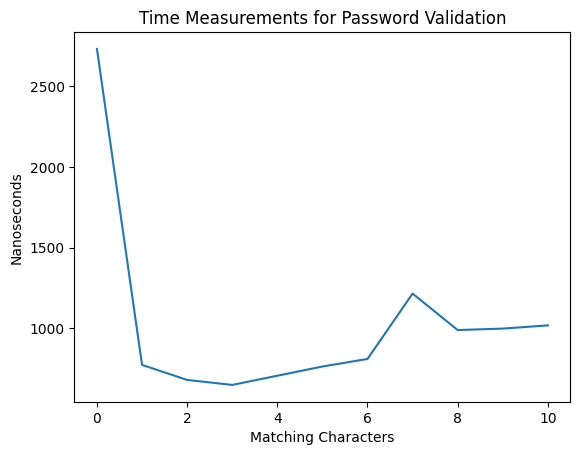

In [3]:
import time

from matplotlib import pyplot as plt

from auth import validate

candidates = [
    "0000000000",
    "5000000000",
    "5500000000",
    "5550000000",
    "5555000000",
    "5555500000",
    "5555550000",
    "5555555000",
    "5555555500",
    "5555555550",
    "5555555555",
]

nanoseconds = []

for i, candidate in enumerate(candidates):
    start = time.time_ns()
    validate(candidate)
    end = time.time_ns()
    nanoseconds.append(end - start)

plt.plot(nanoseconds)
plt.title("Time Measurements for Password Validation")
plt.xlabel("Matching Characters")
plt.ylabel("Nanoseconds")

We can see in the plot above that taking a single time measurement does not provide a good hint to
craft a Timing Attack. In our second version, we use the median time taken (in nanoseconds) of ten
executions of the `validate` method in a single password candidate. And here, the timing component
becomes evident:

Text(0, 0.5, 'Nanoseconds')

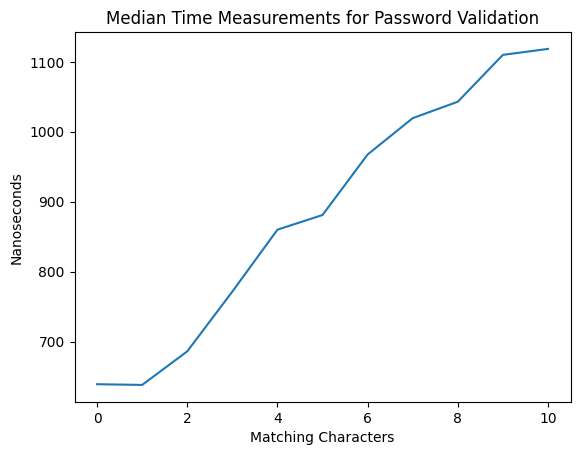

In [4]:
import statistics
import time

from matplotlib import pyplot as plt

from auth import validate

candidates = [
    "0000000000",
    "5000000000",
    "5500000000",
    "5550000000",
    "5555000000",
    "5555500000",
    "5555550000",
    "5555555000",
    "5555555500",
    "5555555550",
    "5555555555",
]

nanoseconds = [0 for _ in range(len(candidates))]

for i, candidate in enumerate(candidates):
    iterations = 10
    results = []
    for j in range(iterations):
        start = time.time_ns()
        validate(candidate)
        end = time.time_ns()
        results.append(end - start)
    nanoseconds[i] = statistics.median(results)

plt.plot(nanoseconds)
plt.title("Median Time Measurements for Password Validation")
plt.xlabel("Matching Characters")
plt.ylabel("Nanoseconds")

## Brute Force Implementation

The brute force implementation consist on exploring the entire search space for the right password,
without using any hint to improve the search. The search space in this case is 10^10, given by the
password length of 10 characters, and 10 available digits available as options.

The brute force implementation search sequentially, starting at "0000000001", and finishing at
"9999999999". To make a *fair* comparison with the other methods, we compute the time taken by the
brute force implementation to find a password that is approximately in the middle of the search
space ("5555555555" in this case).

The brute force implementation is available at [bf.py](./bf.py):

In [9]:
from bf import main

args = {
    "NUMBER_ITERATIONS": 0,
    "BRAKE_ON_SOLUTION": True,
}

%time main(args=args)

Solution = 5555555555
CPU times: user 46min 23s, sys: 0 ns, total: 46min 23s
Wall time: 46min 23s


As we can see in the metrics printed above, the brute force implementation takes about 46
minutes to explore the first half of the search space. This metric will vary depending on the
hardware used to execute the brute force implementation, but here where are providing it as a
comparison point with the other implementations. Also, the brute force implementation doesn't take
advantage of multiprocessing or multithreading, that could help improve this time.

## Genetic Algorithm Implementation

The GA implementation use the median time taken by the password validation method to process a given
candidate password. This value is used as the fitness score for a given member of the population.
The initial population is generated at random, their fitness scores is calculated, and then pair of
parents for the next generation are selected with a probability proportional to their fitness
scores. With the parents pairs selected, a crossover operation is executed to generate the members
of the new generation. Finally, a mutation operation is executed in the next generation.

Once we have the next generation, the algorithm is repeated until it finds a solution (or it reaches
a fixed number of iterations, to prevent going on forever).

The Genetic Algorithm implementation is available at [ga.py](./ga.py)

The following cell runs a Genetic Algorithm to execute a timing attack on the weak password
validation function:

Solution Found

5555555555 Fitness 1398.0



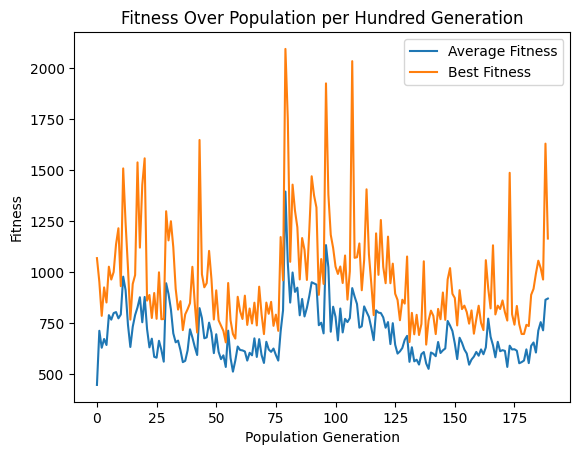

CPU times: user 48 s, sys: 236 ms, total: 48.2 s
Wall time: 48 s


1

In [6]:
from ga import main

args = {
    "POPULATION_SIZE": 100,
    "NUMBER_ITERATIONS": 60000,
    "MUTATION_PCT": 0.5,
    "BRAKE_ON_SOLUTION": True,
    "OUTPUT": "ga",
}

%time main(args=args)

We can see in the results above that the GA implementation took about 40 seconds
to find the actual password ("5555555555" in this case). In the output, we can
see the password found and its fitness, plus the time took by the algorithm to
run. In the plot, we can see the average fitness score and best fitness score
per hundred population generation. Again, these metrics will vary depending on the
hardware used to execute the genetic algorithm implementation, but compared with
the brute force implementation, there is a great improvement. Also, the genetic
algorithm implementation doesn't take advantage of multiprocessing or
multithreading, that could help improve this time.

## Particle Swarm Optimization Implementation

The Particle Swarm Optimization implementation use the median time taken by the password validation
method to process a given candidate password. This value is used as the fitness score for a given
particle of the swam. The initial population of particles and their initial velocities are generated
at random, and their fitness scores are calculated. During each iteration, the particles' fitnesses
are re-evaluated and the particle's personal best as well as the global best of the swarm is
updated. Then each particle's position and velocity is updated based on the current global best and
the hyperparameters including the inertia weight, W, the constants C1 and C2 that determine how the
personal best vs. global best is weighed.

This algorithm is repeated, each iteration moving the particles swarm closer to the maximum until a
solution is found (or it reaches a fixed number of iterations, to prevent going on forever).

The Particle Swarm Optimization implementation is available at [pso.py](./pso.py)

The following cell runs Particle Swarm Optimization to execute a timing attack on the weak password
validation function:

Solution Found

5555555555 Fitness 813



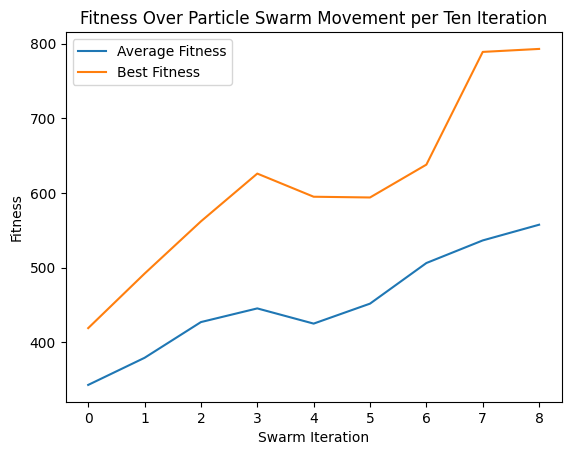

CPU times: user 341 ms, sys: 220 ms, total: 561 ms
Wall time: 346 ms


1

In [7]:
from pso import main

args = {
    "POPULATION_SIZE": 100,
    "NUMBER_ITERATIONS": 10000,
    "OUTPUT": "pso",
    "W": 0.7,
    "C1": 1,
    "C2": 1,
}

%time main(args=args)

We can see in the results above that the PSO implementation took about 300 milliseconds
to find the actual password ("5555555555" in this case). In the output, we can
see the password found and its fitness, plus the time took by the algorithm to
run. In the plot, we can see the average fitness score and best fitness score
per ten iterations. Again, these metrics will vary depending on the
hardware used to execute the genetic algorithm implementation, but compared with
the genetic algorithm implementation, there is a great improvement. Also, the PSO
implementation doesn't take advantage of multiprocessing or
multithreading, that could help improve this time.

## Results

The following code will produce a summary of the results of running the GA implementation after a
certain number of trials.

In [2]:
from trialresults import main

args = {"ALGORITHM": "ga", "TRIALS": 50}

main(args=args)

Average time for ga after 50: 6.1354004969963665 seconds
Success rate for ga after 50: 78.0 %


The following code will produce a summary of the results of running the PSO implementation after a
certain number of trials.

In [1]:
from trialresults import main

args = {"ALGORITHM": "pso", "TRIALS": 50}

main(args=args)

Average time for pso after 50: 0.608202166557312 seconds
Success rate for pso after 50: 100.0 %


## Analysis

From our results it is clear that Particle Swarm Optimization works the best by far. Compared to our
implementation of brute force both our implementation of GA and our PSO outperform it from a huge
margin. For how we simulated the timing attack with it only being ten characters with each character
only being allowed to be numbers it would realistically take considerably longer for each with this
kind of issue meaning that it would make more sense to use one of these two faster strategies.

PSO likely performed much better than the GA since there is only one solution to
the problem, and the PSO algorithm approximates it more efficiently that GA,
given the exploratory nature of GA due to mutations and crossovers.

There are additional experiments that could be interesting to perform, such as:

1. Vary the password length, instead of the fixed 10 characters we used in this prototype.
1. Increase the password complexity, including letters and special characters.
1. Validate if the GA performs better in the case where there are multiple
   acceptable solutions (e.g., guessing existing user names).
1. Implement the Timing Attack using a Ant Colony Optimization algorithm, and
   compare its performance with PSO and GA.
1. Execute the Timing Attack in a real setup, against software vulnerable to
   these kind of attacks, for example a vulnerable website, or outdated encryption
   algorithm.
